## **Бонусная домашняя работа №1.**

Максимальная оценка - 5 баллов.

Бонусные баллы можно суммировать с баллами за другие домашние работы. За домашние работы в сумме нельзя набрать баллов больше, чем сумма баллов за обязательные домашние работы.

Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы.

В данной домашней работе требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

$H(R)$ - критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [1]:
import numpy as np
from typing import Iterable, List, Tuple

In [2]:
from sklearn.datasets import load_boston
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
X["target"] = boston["target"]

/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housin

**Задание 1 (1 балл)**: реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [4]:
def H(R: np.array) -> float:
    """
    Compute impurity criterion for a fixed set of objects R.
    Last column is assumed to contain target value
    """
    #Воспользуемся квадратом отклонения, так как перед нами задача регрессии, тогда минимум в этом выражении будет достигаться при условиях ниже
    return (1 / R.shape[0]) * np.sum((R[:, -1] - np.sum(R[:, -1]) * 1 / R.shape[0]) ** 2)
    #Формула оптимизации взята из лекции Евгения Соколова по ссылке на 4 стр.: https://www.hse.ru/mirror/pubs/share/215285956

def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Split a fixed set of objects R_m given feature number and threshold t
    """
    #Возращаем кортеж из двух ветвей
    #В условии двухзначность: нам дано или название фичи или ее номер. Думаю, имелся ввиду ее номер, так как изначально функции подается numpy array, а не pandas data frame
    R_r = np.array([R_m[i] for i in range(R_m.shape[0]) if R_m[i][int(feature)] >= t])
    R_l = np.array([R_m[i] for i in range(R_m.shape[0]) if R_m[i][int(feature)] < t])
    return R_r, R_l


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Compute error criterion for given split parameters
    """
    #Считаем ошибку по формуле, предотвращая деление на ноль
    R_r = split_node(R_m, feature, t)[0]
    R_l = split_node(R_m, feature, t)[1] 
    
    assert  R_l.shape[0] != 0,  'Пустое разбиение, нужно выбрать другой порог или фичу'
    assert  R_r.shape[0] != 0,  'Пустое разбиение, нужно выбрать другой порог или фичу'
    
    return H(R_r) * R_r.shape[0] / R_m.shape[0] + H(R_l) * R_l.shape[0] / R_m.shape[0]

**Задание 2 (1 балл)**: переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

In [5]:
#Сначала для удобства напишем программу для создания сетки из порогов

def razbyenya(X, feature: int): #X - это DataFrame
    X_ = np.array(X.copy(deep=True))
    #Далее избавимся от наибольшего и наименьшего элемента, ведь если они попадут в порог, то один из классов R_r или R_l окажется нулевым, что помешает подсчету ошибки
    X_max = np.delete(np.array(X_)[:, feature], np.where(np.array(X_)[:, feature] == np.max(np.array(X_)[:, feature])))
    X_min = np.delete(np.array(X_)[:, feature], np.where(np.array(X_)[:, feature] == np.min(np.array(X_)[:, feature])))
    #Программа выдает сетку из 100 шагов от второго наименьшего до второго наибольшего значений фичи
    return np.arange(np.min(X_min), np.max(X_max), (np.max(X_max) - np.min(X_min)) / 100)

In [6]:
X.nunique() #Выберем для интереса фичу с наибольшим количеством уникальных элементов

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
target     229
dtype: int64

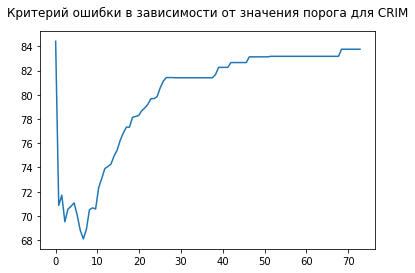

In [7]:
error = [q_error(np.array(X), 0, i) for i in razbyenya(X, 0)] #Генерируем вектор ошибок по разным порогам
plt.plot(razbyenya(X, 0), error)
plt.title(f'Критерий ошибки в зависимости от значения порога для {X.columns[0]}', pad=15)
plt.show()

**Задание 3  (1 балл)**: Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [8]:
#Нужно проминимизировать критерий ошибки
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    #Опять считаем, что фича это integer
    #Реализуем функцию построения значений порогов, которую я делал ранее
    X_max = np.delete(R_m[:, feature], np.where(R_m[:, feature] == np.max(R_m[:, feature])))
    X_min = np.delete(R_m[:, feature], np.where(R_m[:, feature] == np.min(R_m[:, feature])))
    
    t_num = 1000 #Это кол-во t, которое мы будем рассматривать, далее создаем массив с разными порогами
    nabor_t = np.arange(np.min(X_min), np.max(X_max), (np.max(X_max) - np.min(X_min)) / t_num)
    
    error = []

    for t in nabor_t:
        error.append(q_error(R_m, feature, t))

    #Возращаем оптимальный порог разбиения и массив ошибок 
    return nabor_t[error.index(np.min(error))], error

In [9]:
print(get_optimal_split(np.array(X), 0)[0], ': на предыдущем графике видно, что это похоже на правду', sep='')

6.6998386399999985: на графике видно, что это похоже на правду


**Задание 4  (1 балл)**: Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

In [10]:
#Для каждого признака найдем наилучшие разбиения, далее сравним их качество между собой
#Программа может работать 30-40 сек
t_best = []
score = []
for i in range(12):
    t_best.append(get_optimal_split(np.array(X), i)[0])
    score.append(q_error(np.array(X), i, get_optimal_split(np.array(X), i)[0]))

In [11]:
print(f'Тогда нас интересует критерий под номером {score.index(np.min(score))}, который достигает наименьшего значения ошибки в {np.min(score)} при пороге t, равном {t_best[score.index(np.min(score))]}')

Тогда нас интересует критерий под номером 5, который достигает наименьшего значения ошибки в 46.199091677108484 при пороге t, равном 6.940646000000092


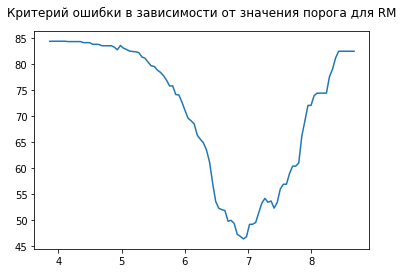

In [12]:
#Строим график тем же способом, что и ранее
error = [q_error(np.array(X), score.index(np.min(score)), i) for i in razbyenya(X, score.index(np.min(score)))]
plt.plot(razbyenya(X, score.index(np.min(score))), error)
plt.title(f'Критерий ошибки в зависимости от значения порога для {X.columns[score.index(np.min(score))]}', pad=15)
plt.show()

 **Задание 5 (1 балл)**: Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

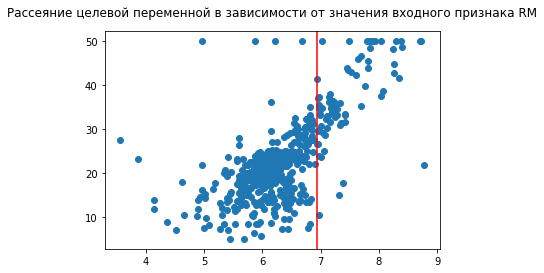

In [13]:
plt.scatter(X[X.columns[score.index(np.min(score))]], X[['target']])
plt.axvline(x=t_best[score.index(np.min(score))], color = 'red')
plt.title(f'Рассеяние целевой переменной в зависимости от значения входного признака {X.columns[score.index(np.min(score))]}', pad=15)
plt.show()

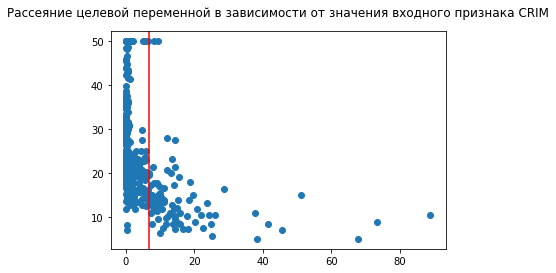

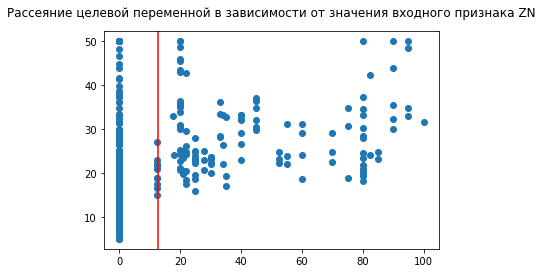

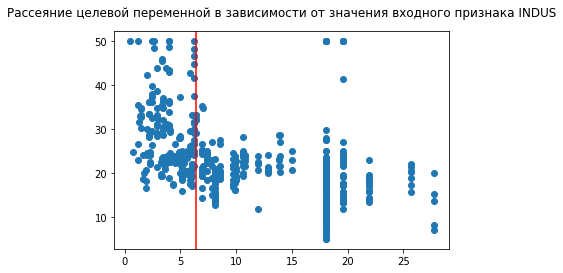

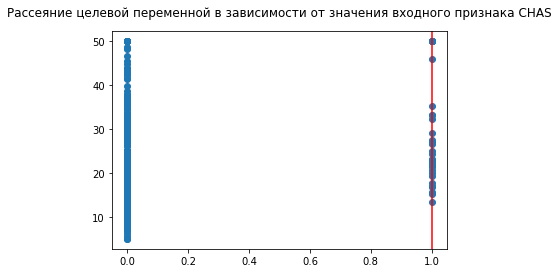

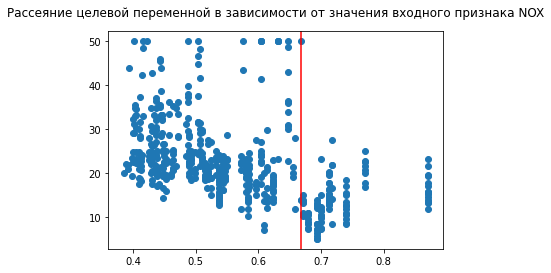

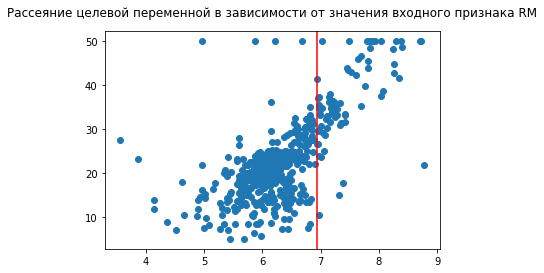

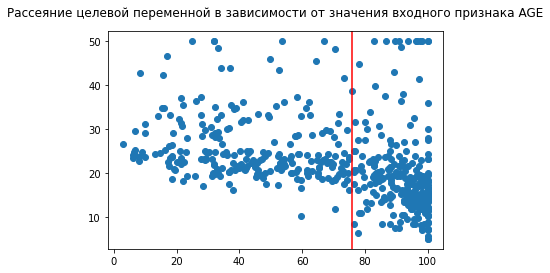

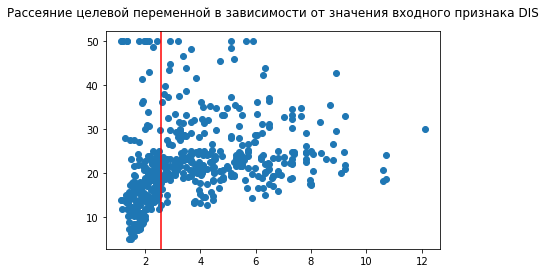

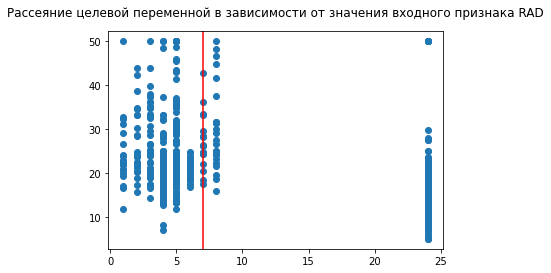

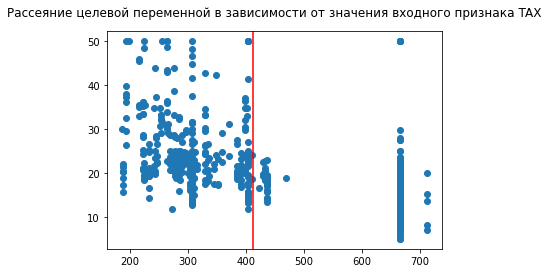

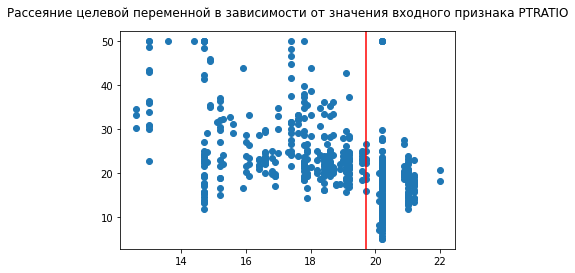

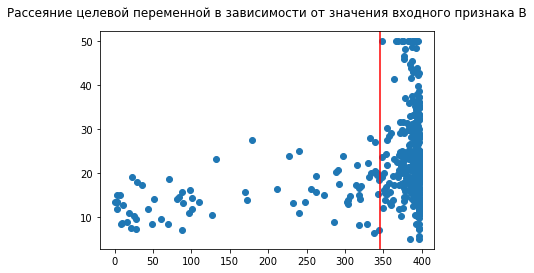

In [14]:
#Также я сделал диаграммы рассеяния для всех признаков
for i in range(12):
    plt.scatter(X[X.columns[i]], X[['target']])
    plt.axvline(x=t_best[i], color = 'red')
    plt.title(f'Рассеяние целевой переменной в зависимости от значения входного признака {X.columns[i]}', pad=15)
    plt.show()